In [1]:
import pathlib
import shlex
import subprocess
import shutil

import polars as pl
import seaborn as sns
from sklearn.linear_model import LinearRegression
import webgwas_analysis.phecodes
import sklearn.metrics
import matplotlib.pyplot as plt
import patchworklib as pw

<Figure size 100x100 with 0 Axes>

In [2]:
shutil.rmtree("data/pheno", ignore_errors=True)
shutil.rmtree("data/gwas", ignore_errors=True)

In [3]:
pheno_root = pathlib.Path("data/pheno")
pheno_root.mkdir(exist_ok=True)

gwas_root = pathlib.Path("data/gwas")
gwas_root.mkdir(exist_ok=True)

# Find ICD-10 codes to keep

In [4]:
cedars_n_occurrences_df = (
    pl.scan_csv("data/cedars-icd.tsv", separator="\t")
    .group_by("icd")
    .len()
    .rename({"len": "n_occurrences"})
)

ukb_n_occurrences_df = (
    pl.scan_csv("../../data/pheno_jan2024.tsv", separator="\t")
    .select(
        "IID", 
        (
            pl.col("^b_[A-Z][0-9]{2}$")
            .sub(2)
            .cast(pl.Boolean)
            .name.map(lambda name: name.replace("b_", ""))
        ),
    )
    .unpivot(index=["IID"], variable_name="icd", value_name="had_icd")
    .filter("had_icd")
    .group_by("icd")
    .len()
    .rename({"len": "n_occurrences"})
)

n_occurrences_df = (
    ukb_n_occurrences_df
    .join(cedars_n_occurrences_df, on=["icd"], suffix="_cedars")
    .rename({"n_occurrences": "n_occurrences_ukb"})
    .collect()
)

cutoff = 1000
icd_codes_to_keep = (
    n_occurrences_df
    .filter(
        pl.col("n_occurrences_ukb").ge(cutoff),
        pl.col("n_occurrences_cedars").ge(cutoff),
    )
    ["icd"]
    .sort()
    .to_list()
)
print(f"Keeping {len(icd_codes_to_keep)} ICD codes")

Keeping 266 ICD codes


# Apply phecodes in Cedars-Sinai data

In [5]:
phecodes = webgwas_analysis.phecodes.load_definitions(
    "../../data/phecodes/phecode_definitions1.2.csv",
    "../../data/phecodes/Phecode_map_v1_2_icd9_icd10cm_09_30_2024.csv"
)
print(f"Loaded {len(phecodes)} phecodes")

phecodes = webgwas_analysis.phecodes.filter_definitions(phecodes, icd_codes_to_keep)
print(f"Filtered to {len(phecodes)} phecodes")

Loaded 1873 phecodes
Filtered to 97 phecodes


In [6]:
cedars_icd_df = (
    pl.read_csv("data/cedars-icd.tsv", separator="\t")
    .with_columns(pl.lit(1).alias("has"))
    .pivot(index="person_id", on="icd", values="has")
    .fill_null(0)
    .select("person_id", *icd_codes_to_keep)
)

min_n_cases = 10
cedars_phecode_df = (
    webgwas_analysis.phecodes.apply_definitions_fuzzy(
        definitions=phecodes, 
        icd_df=cedars_icd_df.drop(["person_id"])
    )
    .pipe(lambda df: webgwas_analysis.phecodes.filter_phenotypes(df, min_n_cases=min_n_cases))
    .select(pl.all().add(2))
    .pipe(lambda df: pl.concat([cedars_icd_df.select("person_id"), df], how="horizontal"))
)
print(f"Filtered to {cedars_phecode_df.shape[1] - 2} phecodes with >= {min_n_cases} cases")

Filtered to 89 phecodes with >= 10 cases


# Approximate phecodes using ICD-10 codes in Cedars-Sinai data

In [7]:
ukb_icd_df = (
    pl.scan_csv("../../data/pheno_jan2024.tsv", separator="\t")
    .select(
        "IID", 
        pl.col("^b_[A-Z][0-9]{2}$").sub(2).name.map(lambda name: name.replace("b_", ""))
    )
    .select("IID", *icd_codes_to_keep)
)
ukb_phecode_df = pl.scan_csv("../2.fit-quality/data/pheno/phecodes.tsv", separator="\t")

ukb_phecodes = ukb_phecode_df.collect_schema().names()[2:]
cedars_phecodes = cedars_phecode_df.columns[1:]
shared_phecodes = set(ukb_phecodes).intersection(cedars_phecodes)
phecodes = sorted(shared_phecodes)
print(f"Finalized to {len(phecodes)} phecodes")

ukb_pheno_df = (
    ukb_icd_df
    .join(ukb_phecode_df, on=["IID"])
    .select("IID", *icd_codes_to_keep, *phecodes)
    .with_columns(pl.col(icd_codes_to_keep).add(2))
    .collect()
)

cedars_pheno_df = (
    cedars_icd_df
    .join(cedars_phecode_df, on=["person_id"])
    .select("person_id", *icd_codes_to_keep, *phecodes)
    .with_columns(pl.col(icd_codes_to_keep).add(2))
)
cedars_pheno_df.head(2)

assert ukb_pheno_df.shape[1] == cedars_pheno_df.shape[1]

Finalized to 52 phecodes


In [8]:
ukb_reg = LinearRegression()
X_ukb = ukb_pheno_df.select(icd_codes_to_keep)
Y_ukb = ukb_pheno_df.select(phecodes)
ukb_reg.fit(X_ukb, Y_ukb)

cedars_reg = LinearRegression()
X_cedars = cedars_pheno_df.select(icd_codes_to_keep)
Y_cedars = cedars_pheno_df.select(phecodes)
cedars_reg.fit(X_cedars, Y_cedars)

LinearRegression()

In [9]:
gwas_pheno_df = (
    pl.concat([
        (
            ukb_pheno_df
            .select(
                pl.col("IID").alias("#FID"),
                "IID", 
                pl.col(phecodes).name.map(lambda name: f"{name}_true")
            )
        ),
        pl.DataFrame(ukb_reg.predict(X_ukb), schema=phecodes).rename(lambda name: f"{name}_ukb"),
        pl.DataFrame(cedars_reg.predict(X_ukb), schema=phecodes).rename(lambda name: f"{name}_cedars"),
    ], how="horizontal")
)
gwas_pheno_df.write_csv(pheno_root / "ukb_phecodes.tsv", separator="\t", null_value="NA")

In [10]:
command = f"""
plink2 \
  --pfile ../../data/geno/ukb_wb_subsampled \
  --pheno {pheno_root.joinpath('ukb_phecodes.tsv').as_posix()} \
  --glm allow-no-covars hide-covar zs \
  --threads 110 \
  --out {gwas_root.joinpath('result').as_posix()}
"""
subprocess.run(shlex.split(command))

PLINK v2.0.0-a.6.0LM AVX2 Intel (11 Nov 2024)      cog-genomics.org/plink/2.0/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to data/gwas/result.log.
Options in effect:
  --glm allow-no-covars hide-covar zs
  --out data/gwas/result
  --pfile ../../data/geno/ukb_wb_subsampled
  --pheno data/pheno/ukb_phecodes.tsv
  --threads 110

Start time: Sun Dec  8 20:55:16 2024
1031943 MiB RAM detected, ~1006805 available; reserving 515971 MiB for main
workspace.
Using up to 110 threads (change this with --threads).
429954 samples (232741 females, 197213 males; 429954 founders) loaded from
../../data/geno/ukb_wb_subsampled.psam.
10000 variants loaded from ../../data/geno/ukb_wb_subsampled.pvar.
156 quantitative phenotypes loaded.
Calculating allele frequencies... done.
--glm linear regression on quantitative phenotypes #1-156: done.
Results written to data/gwas/result.<phenotype name>.glm.linear.zst .
End time: Sun Dec  8 20:55:30 2024


CompletedProcess(args=['plink2', '--pfile', '../../data/geno/ukb_wb_subsampled', '--pheno', 'data/pheno/ukb_phecodes.tsv', '--glm', 'allow-no-covars', 'hide-covar', 'zs', '--threads', '110', '--out', 'data/gwas/result'], returncode=0)

In [11]:
true_gwas_df = (
    pl.scan_csv(gwas_root / "result.*_true.glm.linear.zst", separator="\t", glob=True, include_file_paths="path")
    .select(
        pl.col("path").str.strip_prefix("data/gwas/result.").str.strip_suffix(".glm.linear.zst").str.extract("^(.+)_").alias("phecode"),
        "ID",
        pl.col("T_STAT").pow(2).alias("chisq"),
    )
)
ukb_gwas_df = (
    pl.scan_csv(gwas_root / "result.*_ukb.glm.linear.zst", separator="\t", glob=True, include_file_paths="path")
    .select(
        pl.col("path").str.strip_prefix("data/gwas/result.").str.strip_suffix(".glm.linear.zst").str.extract("^(.+)_").alias("phecode"),
        "ID",
        pl.col("T_STAT").pow(2).alias("chisq"),
    )
)
cedars_gwas_df = (
    pl.scan_csv(gwas_root / "result.*_cedars.glm.linear.zst", separator="\t", glob=True, include_file_paths="path")
    .select(
        pl.col("path").str.strip_prefix("data/gwas/result.").str.strip_suffix(".glm.linear.zst").str.extract("^(.+)_").alias("phecode"),
        "ID",
        pl.col("T_STAT").pow(2).alias("chisq"),
    )
)

gwas_fit_df = (
    pl.concat([
        (
            true_gwas_df
            .join(ukb_gwas_df, on=["phecode", "ID"], suffix="_est")
            .with_columns(
                pl.lit("ukb").alias("source"),
                pl.lit("true").alias("target"),
            )
        ),
        (
            true_gwas_df
            .join(cedars_gwas_df, on=["phecode", "ID"], suffix="_est")
            .with_columns(
                pl.lit("cedars").alias("source"),
                pl.lit("true").alias("target"),
            )
        ),
        (
            ukb_gwas_df
            .join(cedars_gwas_df, on=["phecode", "ID"], suffix="_est")
            .with_columns(
                pl.lit("cedars").alias("source"),
                pl.lit("ukb").alias("target"),
            )
        ),
    ])
    .group_by(["source", "target", "phecode"])
    .agg(pl.corr("chisq", "chisq_est").alias("r"))
    .with_columns(rsq=pl.col("r").pow(2))
    .collect()
)

In [12]:
cedars_pheno_fit_df = (
    pl.concat([
        cedars_pheno_df.select(phecodes),
        pl.DataFrame(
            cedars_reg.predict(
                cedars_pheno_df.select(icd_codes_to_keep)
            ),
            schema=[f"{p}_est" for p in phecodes]
        )
    ], how="horizontal")
    .select([
        pl.corr(phecode, f"{phecode}_est").alias(phecode)
        for phecode in phecodes
    ])
    .unpivot(variable_name="phecode", value_name="r")
    .select("phecode", pl.lit("cedars").alias("source"), pl.lit("cedars").alias("target"), "r", pl.col("r").pow(2).alias("rsq"))
)

pheno_fit_df = (
    gwas_pheno_df
    .select([
        pl.corr(f"{phecode}_true", f"{phecode}_ukb").alias(f"{phecode}_ukb_true")
        for phecode in phecodes
    ] + [
        pl.corr(f"{phecode}_true", f"{phecode}_cedars").alias(f"{phecode}_cedars_true")
        for phecode in phecodes
    ] + [
        pl.corr(f"{phecode}_ukb", f"{phecode}_cedars").alias(f"{phecode}_cedars_ukb")
        for phecode in phecodes
    ])
    .unpivot(variable_name="phecode", value_name="r")
    .select(
        pl.col("phecode").str.split("_").list.get(0),
        pl.col("phecode").str.split("_").list.get(1).alias("source"),
        pl.col("phecode").str.split("_").list.get(2).alias("target"),
        "r",
        pl.col("r").pow(2).alias("rsq"),
    )
    .pipe(lambda df: pl.concat([df, cedars_pheno_fit_df]))
)

In [13]:
summary_df = (
    gwas_fit_df
    .rename({"r": "r_gwas", "rsq": "rsq_gwas"})
    .join(pheno_fit_df, on=["phecode", "source", "target"])
    .rename({"r": "r_pheno", "rsq": "rsq_pheno"})
)
summary_df.write_parquet("data/summary.parquet")
summary_df.head(2)

source,target,phecode,r_gwas,rsq_gwas,r_pheno,rsq_pheno
str,str,str,f64,f64,f64,f64
"""ukb""","""true""","""053""",0.765862,0.586545,0.877059,0.769233
"""ukb""","""true""","""079""",0.665608,0.443035,0.800829,0.641328


# Plot results

In [2]:
summary_df = (
    pl.read_parquet("data/summary.parquet")
    .with_columns(
        pl.when(pl.col("source").eq("cedars") & pl.col("target").eq("ukb"))
        .then(pl.lit("cedars->ukb"))
        .otherwise(
            pl.when(pl.col("source").eq("cedars") & pl.col("target").eq("true"))
            .then(pl.lit("cedars->true"))
            .otherwise(
                pl.when(pl.col("source").eq("ukb") & pl.col("target").eq("true"))
                .then(pl.lit("ukb->true"))
                .otherwise(
                    None
                )
            )
        ).cast(pl.Enum(["cedars->ukb", "cedars->true", "ukb->true"])).alias("label")
    )
)

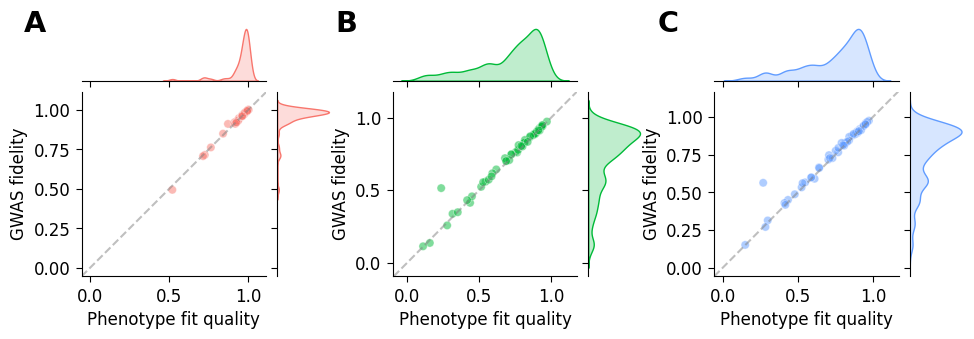

In [3]:
plt.rcParams['figure.dpi'] = 200
palette = ["#F8766D", "#00BA38", "#619CFF"]
sns.set_palette(palette)
pw.overwrite_axisgrid()

cedars_to_est = (
    summary_df
    .filter(pl.col("label").eq("cedars->ukb"))
    .pipe(sns.jointplot, x="rsq_pheno", y="r_gwas", hue="label", alpha=0.5, height=2.5, ratio=3, marginal_kws={'common_norm':False, "bw_adjust": 0.5})
)
plt.xlabel("Phenotype fit quality")
plt.ylabel("GWAS fidelity")
plt.axline((0, 0), slope=1, linestyle="dashed", color="gray", alpha=0.5)
plt.legend([],[], frameon=False)
cedars_to_est.ax_marg_x.text(s="A", y=0.9, x=-0.25, ha="center", transform=cedars_to_est.ax_marg_x.transAxes, fontsize="xx-large", fontweight="heavy")
plt.tight_layout()
cedars_to_est = pw.load_seaborngrid(cedars_to_est, label="cedars_to_est")

cedars_to_true = (
    summary_df
    .filter(pl.col("label").eq("cedars->true"))
    .pipe(sns.jointplot, x="rsq_pheno", y="r_gwas", hue="label", alpha=0.5, height=2.5, ratio=3, marginal_kws={'common_norm':False, "bw_adjust": 0.5})
)
plt.xlabel("Phenotype fit quality")
plt.ylabel("GWAS fidelity")
plt.axline((0, 0), slope=1, linestyle="dashed", color="gray", alpha=0.5)
plt.legend([],[], frameon=False)
cedars_to_true.ax_marg_x.text(s="B", y=0.9, x=-0.25, ha="center", transform=cedars_to_true.ax_marg_x.transAxes, fontsize="xx-large", fontweight="heavy")
plt.tight_layout()
cedars_to_true = pw.load_seaborngrid(cedars_to_true, label="cedars_to_true")

ukb_to_true = (
    summary_df
    .filter(pl.col("label").eq("ukb->true"))
    .pipe(sns.jointplot, x="rsq_pheno", y="r_gwas", hue="label", alpha=0.5, height=2.5, ratio=3, marginal_kws={'common_norm':False, "bw_adjust": 0.5})
)
plt.xlabel("Phenotype fit quality")
plt.ylabel("GWAS fidelity")
plt.axline((0, 0), slope=1, linestyle="dashed", color="gray", alpha=0.5)
plt.legend([],[], frameon=False)
ukb_to_true.ax_marg_x.text(s="C", y=0.9, x=-0.25, ha="center", transform=ukb_to_true.ax_marg_x.transAxes, fontsize="xx-large", fontweight="heavy")
plt.tight_layout()
ukb_to_true = pw.load_seaborngrid(ukb_to_true, label="ukb_to_true")

result = pw.stack([cedars_to_est, cedars_to_true, ukb_to_true], margin=0.)

result.savefig("img/translation.png", facecolor="white", transparent=False)